In [1]:
%reload_ext autoreload
%autoreload 2

import logging
import numpy as np

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

In [2]:
from replay_trajectory_classification.simulate import simulate_neuron_with_place_field
from track_linearization import get_linearized_position
from replay_trajectory_classification import make_track_graph
import numpy as np


def generate_position(traversal_path, track_graph, step_size=0.020, n_traversals=5):
    points = []
    for _ in range(n_traversals):
        for node1, node2 in traversal_path:
            x1, y1 = track_graph.nodes[node1]['pos']
            x2, y2 = track_graph.nodes[node2]['pos']
            dx, dy = x2 - x1, y2 - y1
            dist = np.sqrt(dx**2 + dy**2)
            n_points = int(dist // step_size)
            w = np.linspace(0, 1, n_points)
            points.append((x1 + dx * w, y1 + dy * w))

    return np.concatenate(points, axis=1).T

def get_unique_place_field_centers(place_field_centers):
    return np.unique((place_field_centers * 10_000).astype(int), axis=0) / 10_000

def make_two_environment_data():
    node_positions1 = [(40, 80), # 0
                       (40, 0),  # 1
                       (0, 0),   # 2
                       (0, 80),  # 3
                       (80, 0),  # 4
                       (80, 80), # 5
                       ]

    node_positions2 = [(80, 40),
                       (0, 40),
                       (0, 80),
                       (80, 80),
                       (0, 0),
                       (80, 0),
                       ]
    edges = [(0, 1),
             (1, 2),
             (2, 3),
             (1, 4),
             (4, 5)
            ]

    track_graph1 = make_track_graph(node_positions1, edges)
    track_graph2 = make_track_graph(node_positions2, edges)
    
    traversal_path = [(0, 1), (1, 2), (2, 3), (3, 2), (2, 1), (1, 0), (0, 1), (1, 4), (4, 5), (5, 4), (4, 1), (1, 0)]
    position1 = generate_position(traversal_path, track_graph1)
    position2 = generate_position(traversal_path, track_graph2)
    
    edge_order = ((0, 1),
                  (1, 2),
                  (2, 3),
                  (1, 4),
                  (4, 5)
                 )
    edge_spacing = (30, 0, 30, 0)
    position_df1 = get_linearized_position(position1,
                                           track_graph1,
                                           edge_order=edge_order,
                                           edge_spacing=edge_spacing,
                                           use_HMM=False)
    position_df2 = get_linearized_position(position2,
                                          track_graph2,
                                          edge_order=edge_order,
                                          edge_spacing=edge_spacing,
                                          use_HMM=False)
    
    sampling_frequency = 1000

    place_field_centers1 = generate_position(traversal_path, track_graph1, step_size=10, n_traversals=1)
    place_field_centers1 = get_unique_place_field_centers(place_field_centers1)
    
    spikes1 = np.stack([simulate_neuron_with_place_field(center, position1,
                                                        sampling_frequency=sampling_frequency,
                                                        variance=6.0**2)
                       for center in place_field_centers1], axis=1)
    
    place_field_centers2 = generate_position(traversal_path, track_graph2, step_size=10, n_traversals=1)
    place_field_centers2 = get_unique_place_field_centers(place_field_centers2)
    
    spikes2 = np.stack([simulate_neuron_with_place_field(center, position2,
                                                    sampling_frequency=sampling_frequency,
                                                    variance=6.0**2)
                   for center in place_field_centers2], axis=1)
    
    return (spikes1, spikes2,
            position_df1, position_df2,
            track_graph1, track_graph2, 
            place_field_centers1, place_field_centers2,
            position1, position2,
            edge_order, edge_spacing
           )

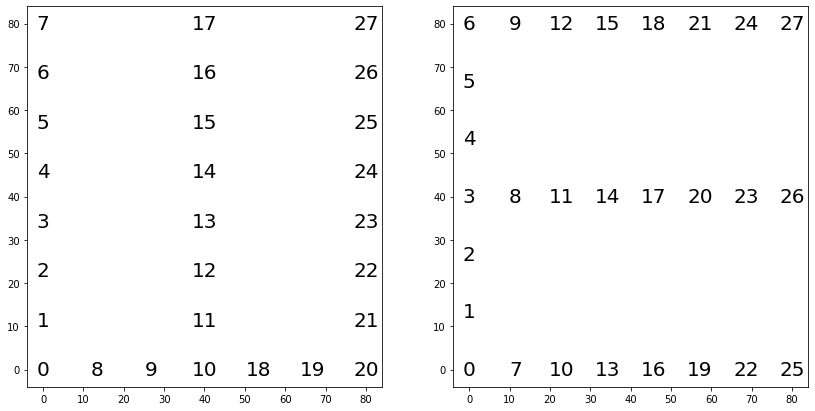

In [3]:
import matplotlib.pyplot as plt

(spikes1, spikes2,
 position_df1, position_df2,
 track_graph1, track_graph2, 
 place_field_centers1, place_field_centers2,
 position1, position2,
 edge_order, edge_spacing
) = make_two_environment_data()

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers1):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers2):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)

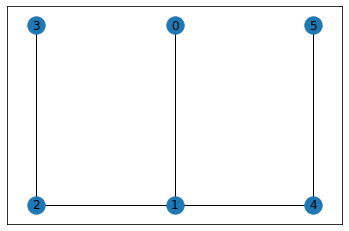

In [4]:
from track_linearization import plot_track_graph

plot_track_graph(track_graph1)

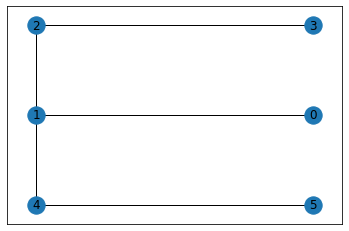

In [5]:
plot_track_graph(track_graph2)

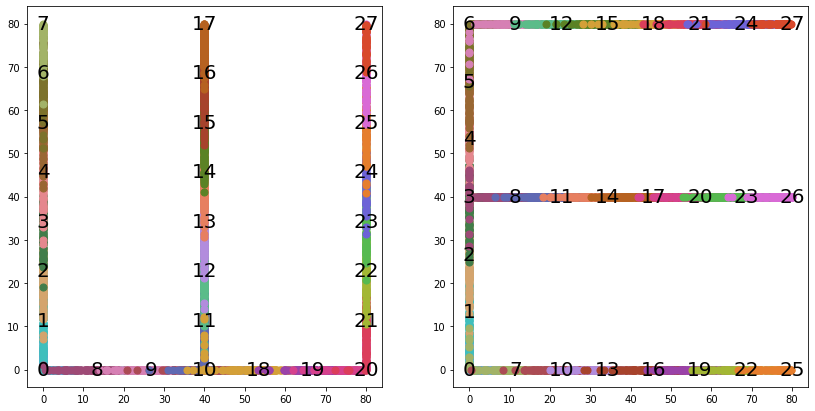

In [6]:
colors = ["#609ed8",
"#3fbfbc",
"#d4a46d",
"#427d4a",
"#e5878e",
"#996733",
"#7c722b",
"#a2b367",
"#9e4a76",
"#d680b4",
"#ab4b54",
"#5f69b3",
"#5bbc89",
"#b28cdd",
"#e77f60",
"#5b8225",
"#a7432c",
"#b66221",
"#d4a038",
"#9a42a8",
"#d6418d",
"#db3e5b",
"#a3b734",
"#56ba50",
"#6d63d7",
"#e67e2d",
"#d96ad6",
"#d8492c"]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0)
for ind, (center, spike) in enumerate(zip(place_field_centers1, spikes1.T)):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)
    axes[0].scatter(position1[spike.astype(bool), 0], position1[spike.astype(bool), 1], c=colors[ind], s=50)
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0)
for ind, (center, spike) in enumerate(zip(place_field_centers2, spikes2.T)):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)
    axes[1].scatter(position2[spike.astype(bool), 0], position2[spike.astype(bool), 1], c=colors[ind], s=50)

In [7]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37017/status,
Dashboard: http://127.0.0.1:37017/status,Workers: 8
Total threads: 64,Total memory: 1.48 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33621,Workers: 8
Dashboard: http://127.0.0.1:37017/status,Total threads: 64
Started: Just now,Total memory: 1.48 TiB
Comm: tcp://127.0.0.1:34469,Total threads: 8
Dashboard: http://127.0.0.1:34655/status,Memory: 188.82 GiB
Nanny: tcp://127.0.0.1:33473,


In [8]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform

environments = (
    Environment('wtrack1', track_graph=track_graph1, edge_order=edge_order, edge_spacing=edge_spacing),
    Environment('wtrack2', track_graph=track_graph2, edge_order=edge_order, edge_spacing=edge_spacing))

continuous_transition_types = [[RandomWalk('wtrack1'),         Uniform('wtrack1', 'wtrack2')],
                               [Uniform('wtrack2', 'wtrack1'), RandomWalk('wtrack2')]]

classifier = SortedSpikesClassifier(
    environments=environments,
    continuous_transition_types=continuous_transition_types,
)
classifier

SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack1', movement_var=6.0, movement_mean=0.0),
                                                     Uniform(environment_name='wtrack1', environment2_name='wtrack2')],
                                                    [Uniform(environment_name='wtrack2', environment2_name='wtrack1'),
                                                     RandomWalk(environment_name='wtrack2', movement_var=6.0, movement_mean=0.0)]],
                       discrete_transiti...
                                     Environment(environment_name='wtrack2', place_bin_size=2.0, track_graph=<networkx.classes.graph.Graph object at 0x7eff9725ed90>, edge_order=((0, 1), (1, 2), (2, 3), (1, 4), (4, 5)), edge_spacing=(30, 0, 30, 0), is_track_interior=None, position_range=None, infer_track_interior=True)),
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
        

In [9]:
position = np.concatenate((position_df1.linear_position.values,
                           position_df2.linear_position.values))
spikes = np.concatenate((spikes1, spikes2))
environment_labels = np.concatenate((['wtrack1'] * spikes1.shape[0],
                                     ['wtrack2'] * spikes2.shape[0],
                                    ))
environment_names_to_state = ['wtrack1', 'wtrack2']
classifier.fit(
    position=position,
    spikes=spikes,
    environment_labels=environment_labels,
    environment_names_to_state=environment_names_to_state,
)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack1', movement_var=6.0, movement_mean=0.0),
                                                     Uniform(environment_name='wtrack1', environment2_name='wtrack2')],
                                                    [Uniform(environment_name='wtrack2', environment2_name='wtrack1'),
                                                     RandomWalk(environment_name='wtrack2', movement_var=6.0, movement_mean=0.0)]],
                       discrete_transiti...
                                     Environment(environment_name='wtrack2', place_bin_size=2.0, track_graph=<networkx.classes.graph.Graph object at 0x7eff9725ed90>, edge_order=((0, 1), (1, 2), (2, 3), (1, 4), (4, 5)), edge_spacing=(30, 0, 30, 0), is_track_interior=None, position_range=None, infer_track_interior=True)),
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
        

In [10]:
# import gc
# client.run(gc.collect)  # collect garbage on all workers

In [11]:
# import ctypes
# def trim_memory() -> int:
#      libc = ctypes.CDLL("libc.so.6")
#      return libc.malloc_trim(0)
# client.run(trim_memory)

In [12]:
classifier.discrete_state_transition_

array([[0.98, 0.02],
       [0.02, 0.98]])

In [13]:
classifier.continuous_state_transition_

[[array([[0.49140289, 0.35210556, 0.1295324 , ..., 0.        , 0.        ,
          0.        ],
         [0.26041277, 0.3634353 , 0.26041277, ..., 0.        , 0.        ,
          0.        ],
         [0.08742513, 0.23764615, 0.33166192, ..., 0.        , 0.        ,
          0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.33166192, 0.23764615,
          0.08742513],
         [0.        , 0.        , 0.        , ..., 0.26041277, 0.3634353 ,
          0.26041277],
         [0.        , 0.        , 0.        , ..., 0.1295324 , 0.35210556,
          0.49140289]]),
  array([[0.00625, 0.00625, 0.00625, ..., 0.00625, 0.00625, 0.00625],
         [0.00625, 0.00625, 0.00625, ..., 0.00625, 0.00625, 0.00625],
         [0.00625, 0.00625, 0.00625, ..., 0.00625, 0.00625, 0.00625],
         ...,
         [0.00625, 0.00625, 0.00625, ..., 0.00625, 0.00625, 0.00625],
         [0.00625, 0.00625, 0.00625, ..., 0.00625, 0.00625, 0.00625],
         [0.00625, 0.00625, 0.00

In [14]:
classifier.place_fields_

{('wtrack1',
  0): <xarray.DataArray (position: 162, neuron: 28)>
 array([[0.00030501, 0.00033974, 0.00031989, ..., 0.00031839, 0.00028823,
         0.00020077],
        [0.00029392, 0.00032624, 0.00030781, ..., 0.00030633, 0.00027814,
         0.00019685],
        [0.00028421, 0.00031446, 0.00029725, ..., 0.00029579, 0.00026929,
         0.00019337],
        ...,
        [0.0003077 , 0.00034286, 0.00032276, ..., 0.00033281, 0.00300767,
         0.00251543],
        [0.00031376, 0.00035036, 0.0003294 , ..., 0.00031346, 0.00155645,
         0.00219158],
        [0.00032057, 0.00035881, 0.00033688, ..., 0.00031106, 0.00074783,
         0.00178501]])
 Coordinates:
   * position  (position) float64 1.0 3.0 5.0 7.0 9.0 ... 373.0 375.0 377.0 379.0
 Dimensions without coordinates: neuron,
 ('wtrack2',
  0): <xarray.DataArray (position: 162, neuron: 28)>
 array([[0.00031429, 0.00031141, 0.00035471, ..., 0.00022545, 0.00942421,
         0.00020944],
        [0.00030259, 0.00029996, 0.00033965, 

In [15]:
from dataclasses import dataclass


@dataclass(order=True)
class ObservationModel:
    state_name: str = None
    environment_name: str = ''
    encoding_group: str = None
        
        
[ObservationModel(environment_name='wtrack1'),
 ObservationModel(environment_name='wtrack2')
]

blah = [ObservationModel(environment_name='wtrack1', encoding_group='Inbound'),
        ObservationModel(environment_name='wtrack1', encoding_group='Inbound'),
        ObservationModel(environment_name='wtrack1', encoding_group='Outbound'),
        ObservationModel(environment_name='wtrack1', encoding_group='Outbound'),
        ]

np.unique(blah)

array([ObservationModel(state_name=None, environment_name='wtrack1', encoding_group='Inbound'),
       ObservationModel(state_name=None, environment_name='wtrack1', encoding_group='Outbound')],
      dtype=object)

In [16]:
def make_sequence(neuron_sequence, n_neurons=28, step=1):
    neuron_sequence = np.asarray(neuron_sequence)
    n_time = step * len(neuron_sequence)
    spike_time_ind = np.arange(0, n_time, step)
    spikes = np.zeros((n_time, n_neurons))
    
    spikes[(spike_time_ind, neuron_sequence)] = 1
    
    return spikes

test_spikes = make_sequence([8, 11, 14, 17, 20, 23], 28, 5)

In [17]:
results, time, state_names = classifier.predict(test_spikes)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


In [18]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform

environments2 = (
    Environment('wtrack1', track_graph=track_graph1, edge_order=edge_order, edge_spacing=edge_spacing))

continuous_transition_types2 = [[RandomWalk('wtrack1'), Uniform('wtrack1')],
                                [Uniform('wtrack1'),    Uniform('wtrack1')]]

classifier2 = SortedSpikesClassifier(
    environments=environments2,
    continuous_transition_types=continuous_transition_types2,
)
classifier2.fit(
    position=position_df1.linear_position.values,
    spikes=spikes1,
)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack1', movement_var=6.0, movement_mean=0.0),
                                                     Uniform(environment_name='wtrack1', environment2_name=None)],
                                                    [Uniform(environment_name='wtrack1', environment2_name=None),
                                                     Uniform(environment_name='wtrack1', environment2_name=None)]],
                       discrete_transition_type=DiagonalDiscrete(...
                       environments=(Environment(environment_name='wtrack1', place_bin_size=2.0, track_graph=<networkx.classes.graph.Graph object at 0x7eff9725ed60>, edge_order=((0, 1), (1, 2), (2, 3), (1, 4), (4, 5)), edge_spacing=(30, 0, 30, 0), is_track_interior=None, position_range=None, infer_track_interior=True),),
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
        

In [19]:
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])
results2

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


<xarray.Dataset>
Dimensions:            (time: 30, state: 2, position: 162)
Coordinates:
  * time               (time) int64 0 1 2 3 4 5 6 7 ... 22 23 24 25 26 27 28 29
  * position           (position) float64 1.0 3.0 5.0 7.0 ... 375.0 377.0 379.0
  * state              (state) <U10 'Continuous' 'Fragmented'
Data variables:
    likelihood         (time, state, position) float64 0.04349 0.04182 ... 1.0
    causal_posterior   (time, state, position) float64 0.001677 ... 0.004436
    acausal_posterior  (time, state, position) float64 0.00159 ... 0.004436

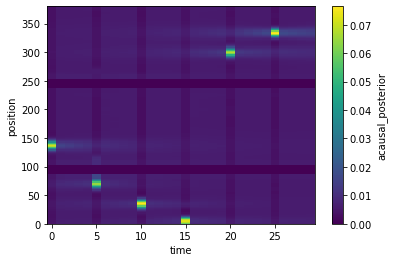

In [20]:
results2.acausal_posterior.sum('state').plot(x='time', y='position')

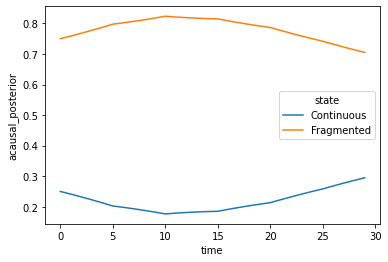

In [21]:
results2.acausal_posterior.sum('position').plot(x='time', hue='state')

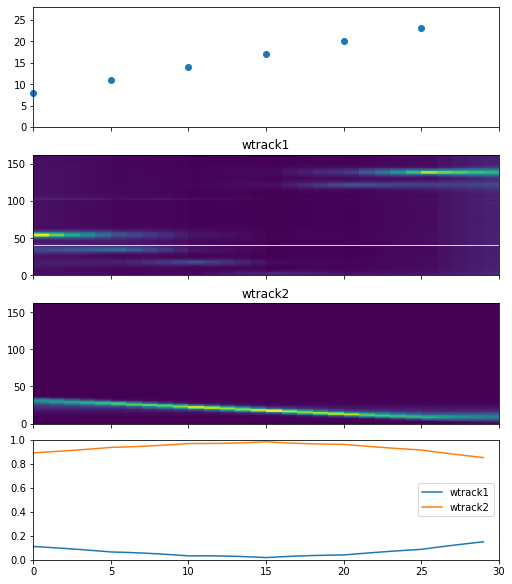

In [22]:
import copy

fig, axes = plt.subplots(4, 1, constrained_layout=True, figsize=(7, 8), sharex=True)
time_ind, spike_ind = np.nonzero(test_spikes)
mask1 = ~classifier.environments[0].is_track_interior_
mask1 = mask1.astype(float)
mask1[mask1 == 1] = np.nan
mask1[mask1 == 0] = 1
mask1 = mask1[:, np.newaxis]

mask2 = classifier.environments[1].is_track_interior_[:, np.newaxis]
mask2[mask2.astype(bool)] = np.nan

cmap = copy.copy(plt.cm.get_cmap('viridis'))
cmap.set_bad(color="lightgrey", alpha=1.0)

axes[0].scatter(time_ind, spike_ind, clip_on=False)
axes[0].set_ylim((0, 28))
axes[1].pcolormesh(results['acausal_posterior'][:, 0].T * mask1, cmap=cmap)
axes[1].set_title('wtrack1')
axes[2].pcolormesh(results['acausal_posterior'][:, 1].T * mask2, cmap=cmap)
axes[2].set_title('wtrack2')
axes[3].plot(results['acausal_posterior'].sum(axis=2), label=['wtrack1', 'wtrack2'])
axes[3].set_ylim((0, 1))
axes[3].legend()